# **Aex and Machine learning models to predict lung function impairment**

### **Set up environnement**

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
import os

from scipy import stats


from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder,  StandardScaler
from sklearn import preprocessing

from sklearn.compose import ColumnTransformer
from sklearn.compose import make_column_selector

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier

from sklearn.model_selection import cross_validate
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RandomizedSearchCV


from sklearn.metrics import make_scorer#, roc_auc_score
from sklearn.metrics import f1_score, confusion_matrix, classification_report, roc_auc_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import learning_curve

### **Create a function to process data from github url**

In [ ]:
def create_data_for_analysis (url):

  # read data from url
  df = pd.read_csv(url)

  # Transformation of FEV1/FVC ratio as decimal number
  df["vemscvf1"]= df["vemscvf1"]/100
  # Correct LLN of CPT to account for ethinicity
  df['LLN_CPT'] = df['LLN_CPT']* (1-0.12)

  # Creating mask and subgroups
    ## obstructive patients
  masq_osb = ((df['vemscvf1'] < df['FEV1FVC_LLN']) & (df['cvf1'] > df['FVC_LLN'])) | ((df['vemscvf1'] >= df['FEV1FVC_LLN'])  & (df['cvf1']<df['FVC_LLN']) & (df['cpt1']>df['LLN_CPT']))
  df_obs = df[masq_osb]
    ## restrictuve patients
  masq_rest = ((df['vemscvf1'] >= df.FEV1FVC_LLN) & (df.cvf1 < df.FVC_LLN) & (df.cpt1 < df.LLN_CPT))
  df_rest = df[masq_rest]
    ## patients with mixed syndrome
  masq_mixt = (df['vemscvf1'] < df.FEV1FVC_LLN) & (df.cvf1 < df.FVC_LLN) & (df.cpt1 < df.LLN_CPT)
  df_mixt = df[masq_mixt]
    ## normal patients = patients with normal lung function
  masq_normaux = (df.cvf1>=df.FVC_LLN) & (df['vemscvf1'] > df.FEV1FVC_LLN)
  df_normaux  = df[masq_normaux]

  # Generate a variable with type of ventilatory defect = "type_trouble"
  df_normaux["type_trouble"] = 0
  df_obs["type_trouble"] = 1
  df_rest["type_trouble"] = 2
  df_mixt["type_trouble"] = 3

  # Create dataframe combining all 4 subgroups = df_all
  df_all = pd.concat([df_normaux, df_obs, df_rest, df_mixt], axis = 0)
  # Create dataframe combining all subgroups except df_mixt (low number of participants with mixed defect)= df_analysis
  df_analysis = pd.concat([df_normaux, df_obs, df_rest], axis = 0)

  return df_all, df_analysis


In [ ]:
# Obtain dataframe for analysis from defined url
df_all, df_analysis = create_data_for_analysis (url= "https://raw.githubusercontent.com/pefura/lung-function/main/Aex_dataset.csv")

In [ ]:
# Verify shape of dataset
print("df_all shape:", df_all.shape)
print("df_analysis shape:", df_analysis.shape)

df_all shape: (387, 65)
df_analysis shape: (381, 65)


In [ ]:
df_analysis.columns

Index(['lieu', 'date', 'modercueil', 'enqueteur', 'enquete', 'num', 'age',
       'sexe', 'taille', 'vem1', 'cvf1', 'vemscvf1', 'dem2575ls1', 'texs1',
       'aex1', 'vemscv1', 'vem2', 'cvf2', 'vemscvf2', 'depls2', 'dem25ls2',
       'dem50ls2', 'dem75ls2', 'dem2575ls2', 'texs2', 'aex2', 'vemscv2',
       'cpt1', 'vr1', 'vgt1', 'vrcpt1', 'ic1', 'vgtcpt1', 'gawlskpa1',
       'srawkpa1', 'rvakpals1', 'sgawkpas1', 'cpt2', 'vr2', 'vgt2', 'vrcpt2',
       'ic2', 'vgtcpt2', 'gawlskpa2', 'srawkpa2', 'rvakpals2', 'sgawkpas2',
       'FEV1_predicted', 'FEV1FVC_predicted', 'FVC_predicted',
       'FEF2575_predicted', 'FEV1_zscore', 'FEV1FVC_zscore', 'FVC_zscore',
       'FEF2575_zscore', 'FEV1_LLN', 'FEV1FVC_LLN', 'FEV1FVC_ULN', 'FVC_LLN',
       'FEF2575_LLN', 'CPT_pred', 'LLN_CPT', 'poids', 'bmi', 'type_trouble'],
      dtype='object')

In [ ]:
df_analysis["FEV1_predicted"].describe()

count    381.000000
mean       2.477958
std        0.690502
min        1.180000
25%        1.940000
50%        2.490000
75%        2.920000
max        4.900000
Name: FEV1_predicted, dtype: float64

### **Create dataset with usefull variables for the specific thesis question**

In [ ]:
df = df_analysis[['sexe', 'age', 'vem1','cvf1','vemscvf1','FEV1_zscore', 'FEV1FVC_zscore', 'FVC_zscore','aex1', 'bmi', 'type_trouble']]
df.head(5)

,sexe,age,vem1,cvf1,vemscvf1,FEV1_zscore,FEV1FVC_zscore,FVC_zscore,aex1,bmi,type_trouble
0,1,80,2.19,2.57,0.85,0.76,0.94,0.21,7.39,27.250887,0
1,2,88,1.01,1.28,0.79,-1.25,0.08,-1.36,1.49,35.599858,0
2,2,66,2.31,2.61,0.89,1.12,1.12,0.59,8.35,27.250887,0
3,1,35,3.00,3.37,0.89,-1.37,0.73,-1.61,21.19,35.174011,0
4,1,50,3.08,3.86,0.80,0.75,-0.32,0.94,12.16,40.391156,0


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 381 entries, 0 to 384
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   sexe            381 non-null    int64  
 1   age             381 non-null    int64  
 2   vem1            381 non-null    float64
 3   cvf1            381 non-null    float64
 4   vemscvf1        381 non-null    float64
 5   FEV1_zscore     381 non-null    float64
 6   FEV1FVC_zscore  381 non-null    float64
 7   FVC_zscore      381 non-null    float64
 8   aex1            381 non-null    float64
 9   bmi             381 non-null    float64
 10  type_trouble    381 non-null    int64  
dtypes: float64(8), int64(3)
memory usage: 35.7 KB


In [ ]:
# Correcting type of variables
df["sexe"] = df["sexe"].astype("category")
df["type_trouble"] = df["type_trouble"].astype("category")

# labels categorical modalities
df["sexe"] = df["sexe"].replace([1, 2], ["Masculin", "Feminin"])
df["type_trouble"] = df["type_trouble"].replace([0, 1, 2], ["Absence de trouble", "TVO", "TVR"])

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 381 entries, 0 to 384
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   sexe            381 non-null    category
 1   age             381 non-null    int64   
 2   vem1            381 non-null    float64 
 3   cvf1            381 non-null    float64 
 4   vemscvf1        381 non-null    float64 
 5   FEV1_zscore     381 non-null    float64 
 6   FEV1FVC_zscore  381 non-null    float64 
 7   FVC_zscore      381 non-null    float64 
 8   aex1            381 non-null    float64 
 9   bmi             381 non-null    float64 
 10  type_trouble    381 non-null    category
dtypes: category(2), float64(8), int64(1)
memory usage: 30.8 KB


### **Description of categorical variables**

In [ ]:
df["sexe"].value_counts()

Feminin     209
Masculin    172
Name: sexe, dtype: int64

In [ ]:
100 * df["sexe"].value_counts(normalize = True) # en %

Feminin     54.855643
Masculin    45.144357
Name: sexe, dtype: float64

In [ ]:
df["type_trouble"].value_counts()

Absence de trouble    301
TVO                    56
TVR                    24
Name: type_trouble, dtype: int64

In [ ]:
100 * df["type_trouble"].value_counts(normalize = True) #  en %

Absence de trouble    79.002625
TVO                   14.698163
TVR                    6.299213
Name: type_trouble, dtype: float64

### **Description of quantitative variables in full dataset**

<Axes: xlabel='age', ylabel='Count'>

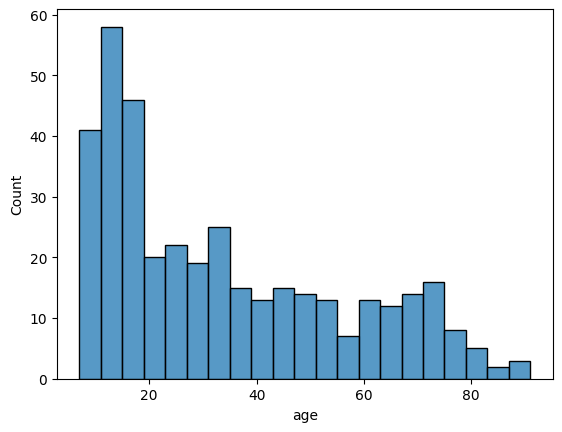

In [ ]:
# Histograme of age
sns.histplot(data=df, x="age",binwidth=4)

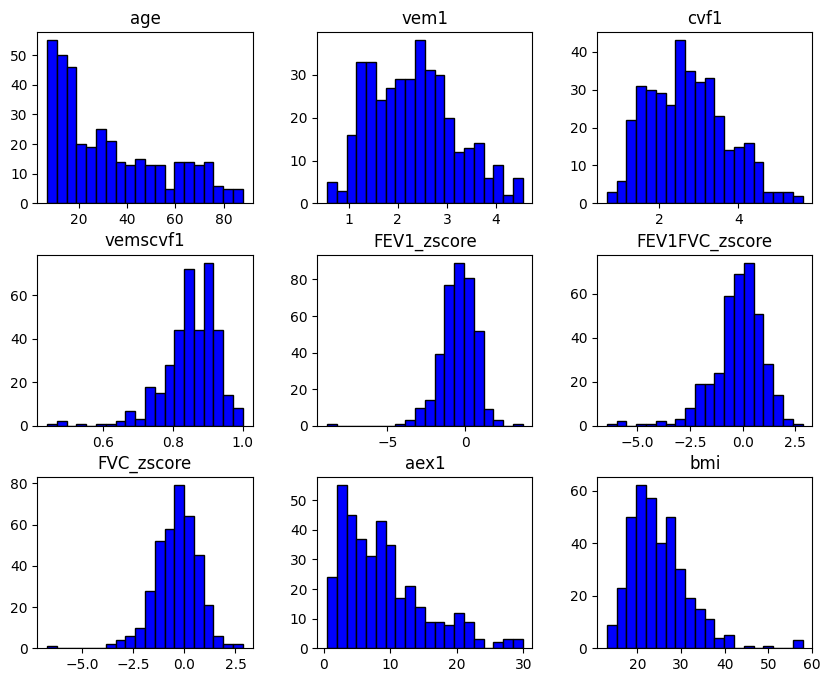

In [ ]:
# Histogram of quantitative variables: normal distribution or not?
def multi_hist(data, bins):
    fig = plt.figure (figsize= (10,8))
    ax = fig.gca()
    hist = data.iloc[:-1].hist(ax = ax, bins=bins, grid= False, edgecolor = "black", color = "blue")

multi_hist(data = df.select_dtypes(include = np.number), bins=20)
# No variable is normaly distributed.

In [ ]:
df.describe()

,age,vem1,cvf1,vemscvf1,FEV1_zscore,FEV1FVC_zscore,FVC_zscore,aex1,bmi
count,381.000000,381.000000,381.000000,381.000000,381.000000,381.000000,381.000000,381.000000,381.000000
mean,33.511811,2.307349,2.712546,0.851076,-0.460562,-0.221848,-0.385898,8.823255,24.982569
std,22.168802,0.854290,0.982595,0.077881,1.149186,1.225242,1.065652,6.210537,6.631738
min,7.000000,0.560000,0.670000,0.440000,-8.870000,-6.440000,-6.710000,0.520000,13.017751
25%,14.000000,1.580000,1.930000,0.820000,-1.070000,-0.710000,-1.100000,3.840000,20.429418
50%,28.000000,2.290000,2.650000,0.860000,-0.420000,-0.060000,-0.290000,7.700000,23.828125
75%,50.000000,2.840000,3.340000,0.900000,0.290000,0.530000,0.360000,11.880000,28.395062
max,88.000000,4.540000,5.630000,1.000000,3.680000,2.840000,2.860000,29.890000,57.812500


### **Spirometric parameters in function of type of defect and comparison using KW test**

In [ ]:
# define subgroups for comparison
df_obs = df[df["type_trouble"] =="TVO"]
df_rest = df[df["type_trouble"] =="TVR"]
df_normaux = df[df["type_trouble"] =="Absence de trouble"]
df_obs.shape, df_rest.shape, df_normaux.shape

((56, 11), (24, 11), (301, 11))

In [ ]:
# For FEV1
df[["vem1", "type_trouble"]].groupby("type_trouble").describe()

vem1                                                   \
                    count      mean       std   min     25%    50%     75%   
type_trouble                                                                 
Absence de trouble  301.0  2.466977  0.811039  0.91  1.8200  2.410  3.0000   
TVO                  56.0  1.817857  0.751841  0.56  1.2975  1.645  2.2675   
TVR                  24.0  1.447500  0.661745  0.58  1.0175  1.255  1.9100   

                          
                     max  
type_trouble              
Absence de trouble  4.54  
TVO                 4.10  
TVR                 2.82

In [ ]:
# For FVC
df[["cvf1", "type_trouble"]].groupby("type_trouble").describe()

cvf1                                                     
                    count      mean       std   min     25%    50%   75%   max
type_trouble                                                                  
Absence de trouble  301.0  2.845150  0.930740  1.23  2.1200  2.780  3.45  5.48
TVO                  56.0  2.434464  1.046730  0.67  1.6275  2.215  3.15  5.63
TVR                  24.0  1.698333  0.735259  0.74  1.1900  1.425  2.48  3.21

In [ ]:
stats.kruskal(df_obs["cvf1"],df_rest["cvf1"],df_normaux["cvf1"])

KruskalResult(statistic=36.795288594487495, pvalue=1.0233038349242663e-08)

In [ ]:
# For FEV1/FVC ratio
df[["vemscvf1", "type_trouble"]].groupby("type_trouble").describe()

vemscvf1                                                   \
                      count      mean       std   min     25%    50%     75%   
type_trouble                                                                   
Absence de trouble    301.0  0.867841  0.054866  0.69  0.8400  0.870  0.9000   
TVO                    56.0  0.763036  0.115600  0.44  0.7175  0.775  0.8225   
TVR                    24.0  0.846250  0.080098  0.68  0.7875  0.860  0.8925   

                          
                     max  
type_trouble              
Absence de trouble  1.00  
TVO                 1.00  
TVR                 0.99

In [ ]:
stats.kruskal(df_obs["vemscvf1"],df_rest["vemscvf1"],df_normaux["vemscvf1"])

KruskalResult(statistic=53.349339407872584, pvalue=2.6021848315732458e-12)

In [ ]:
# For FEF1 Zscore
df[["FEV1_zscore", "type_trouble"]].groupby("type_trouble").describe()

FEV1_zscore                                          \
                         count      mean       std   min     25%   50%   
type_trouble                                                             
Absence de trouble       301.0 -0.113924  0.827485 -1.95 -0.7000 -0.19   
TVO                       56.0 -1.581839  1.411916 -8.87 -2.0175 -1.37   
TVR                       24.0 -2.191667  0.600034 -3.68 -2.5900 -2.08   

                                  
                       75%   max  
type_trouble                      
Absence de trouble  0.3800  3.68  
TVO                -0.8800  1.09  
TVR                -1.7475 -1.25

In [ ]:
stats.kruskal(df_obs["FEV1_zscore"],df_rest["FEV1_zscore"],df_normaux["FEV1_zscore"])

KruskalResult(statistic=125.88834359625042, pvalue=4.609921394174925e-28)

In [ ]:
# For FVC Z score
df[["FVC_zscore", "type_trouble"]].groupby("type_trouble").describe()

FVC_zscore                                                  \
                        count      mean       std   min    25%    50%     75%   
type_trouble                                                                    
Absence de trouble      301.0 -0.155528  0.811309 -1.63 -0.770 -0.190  0.4500   
TVO                      56.0 -0.820946  1.462924 -6.71 -1.715 -0.480  0.0500   
TVR                      24.0 -2.260000  0.488609 -3.25 -2.550 -2.165 -1.8425   

                          
                     max  
type_trouble              
Absence de trouble  2.86  
TVO                 1.74  
TVR                -1.73

In [ ]:
stats.kruskal(df_obs["FVC_zscore"],df_rest["FVC_zscore"],df_normaux["FVC_zscore"])

KruskalResult(statistic=72.69917718086565, pvalue=1.635212716091748e-16)

In [ ]:
# For FEV1/FVC Z score
df[["FEV1FVC_zscore", "type_trouble"]].groupby("type_trouble").describe()

FEV1FVC_zscore                                          \
                            count     mean       std   min     25%    50%   
type_trouble                                                                
Absence de trouble          301.0  0.07285  0.777748 -1.53 -0.5100  0.050   
TVO                          56.0 -1.92450  1.761176 -6.44 -2.6200 -2.095   
TVR                          24.0  0.05500  1.104804 -1.58 -0.7725 -0.220   

                                
                     75%   max  
type_trouble                    
Absence de trouble  0.57  2.01  
TVO                -1.53  2.15  
TVR                 0.78  2.84

In [ ]:
stats.kruskal(df_obs["FEV1FVC_zscore"],df_rest["FEV1FVC_zscore"],df_normaux["FEV1FVC_zscore"])

KruskalResult(statistic=64.74731405901939, pvalue=8.715642200889244e-15)

In [ ]:
# For Aex
df[["aex1", "type_trouble"]].groupby("type_trouble").describe()

aex1                                                  \
                    count      mean       std   min   25%    50%      75%   
type_trouble                                                                
Absence de trouble  301.0  9.908173  6.237702  1.05  4.89  8.770  12.9500   
TVO                  56.0  5.222679  4.330754  0.52  2.25  3.555   7.1325   
TVR                  24.0  3.617917  3.107423  0.52  1.63  2.275   5.1800   

                           
                      max  
type_trouble               
Absence de trouble  29.89  
TVO                 22.04  
TVR                 11.20

In [ ]:
stats.kruskal(df_obs["aex1"],df_rest["aex1"],df_normaux["aex1"])

KruskalResult(statistic=61.9901933834842, pvalue=3.4593980853847213e-14)

Text(0, 0.5, 'Aex')

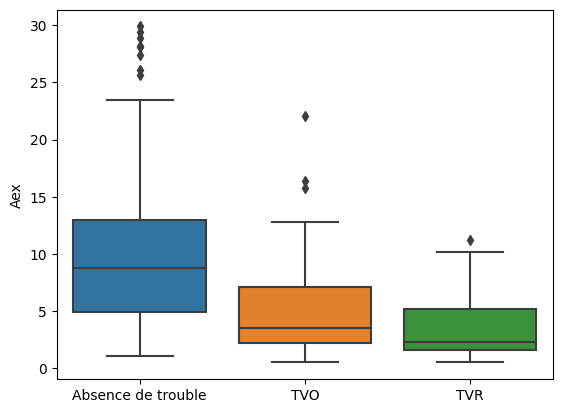

In [ ]:
sns.boxplot(data=df, y="aex1", x = "type_trouble")
plt.xlabel("")
plt.ylabel("Aex")

### **Training and testing on whole dataset**

In [ ]:
# Spliting data , 50% in train and 50% in test set
X = df_analysis[['vem1','cvf1','vemscvf1','FEV1FVC_zscore','aex1']]
y = df_analysis['type_trouble']
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.5, random_state=0)

print("X train shape:", X_train.shape)
print("X test shape:", X_test.shape)

X train shape: (190, 5)
X test shape: (191, 5)


In [ ]:
# Define function to evaluate models
def evaluation(model):
    ypred = model.predict(X_test)
    y_score = model.predict_proba(X_test)

    print(confusion_matrix(y_test, ypred))
    print(classification_report(y_test, ypred))

In [ ]:
# preprocessing data and define models and evently pipeline
random_state = 0
preprocessor= ColumnTransformer(transformers=[('scaler',  StandardScaler(), make_column_selector(dtype_include=np.number))])

# Logistic regression model
LR_model = Pipeline(steps=[('preprocessor', preprocessor ),
                   ('LR', LogisticRegression(random_state=random_state)) ])

# Random forest model
RF_model =  RandomForestClassifier(random_state=random_state)

# Gradient boosting model
GB_model =  GradientBoostingClassifier(random_state=random_state)

# ANN model
MLPC = Pipeline(steps=[('preprocessor', preprocessor ),
                   ('MLPC', MLPClassifier(random_state=random_state))
                   ])


### **Searching hyperparameters by randomized search and compute F1 score average**

In [ ]:
# Definition a function for F1 computation
scoring = {'f1': make_scorer(f1_score, average='weighted')}
cv = StratifiedKFold(n_splits = 5)

def average_score_on_cross_val_classification(clf, X, y, scoring=scoring, cv=cv):
    """
    Evaluates a given model/estimator using cross-validation
    and returns a dict containing the absolute values of the average (mean) scores
    for classification models.

    clf: scikit-learn classification model
    X: features (no labels)
    y: labels
    scoring: a dictionary of scoring metrics
    cv: cross-validation strategy
    """
    # Score metrics on cross-validated dataset
    scores_dict = cross_validate(clf, X, y, scoring=scoring, cv=cv, n_jobs=-1)

    # return the average scores for each metric
    print("mean F1 score:", np.mean(pd.DataFrame(scores_dict)["test_f1"]))
    print("standard deviation:", np.std(pd.DataFrame(scores_dict)["test_f1"]))
    return pd.DataFrame(scores_dict)

In [ ]:
# For Logistic regression model
distributions = dict(LR__C=np.arange(1,10),
                     LR__max_iter = np.arange(1,10000),
                     LR__solver = ['lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga'],
                     LR__penalty=['l2', 'l1'])

LR_RS = RandomizedSearchCV(LR_model, distributions, random_state=random_state,scoring = 'f1')
LR_search = LR_RS.fit(X_train, y_train)
print(" Logistic regression best params:",LR_search.best_params_)

 Logistic regression best params: {'LR__solver': 'saga', 'LR__penalty': 'l1', 'LR__max_iter': 5478, 'LR__C': 3}


In [ ]:
# F1 score for logistic regression in CV. This is weighted average
average_score_on_cross_val_classification(LR_search, X=X_train, y=y_train)

mean F1 score: 0.8128711201079621
standard deviation: 0.04092360871558641


,fit_time,score_time,test_f1
0,1.832585,0.010841,0.770243
1,2.150093,0.012466,0.834008
2,2.366724,0.005123,0.866447
3,2.893778,0.005288,0.759919
4,1.284066,0.002917,0.833738


In [ ]:
# for random forest
distributions = dict(max_depth=np.arange(1,10),
                     n_estimators=np.arange(60,600))

RF_RS = RandomizedSearchCV(RF_model, distributions, random_state=random_state,scoring = 'f1')
RF_search = RF_RS.fit(X_train, y_train)
RF_search.best_params_
print(" Random Forest best params:",RF_search.best_params_)


 Random Forest best params: {'n_estimators': 92, 'max_depth': 6}


In [ ]:
# F1 score for random forest in CV
average_score_on_cross_val_classification(RF_search, X=X_train, y=y_train)

mean F1 score: 0.8642264508571671
standard deviation: 0.044560795710371894


,fit_time,score_time,test_f1
0,38.937375,0.011316,0.850564
1,39.005076,0.011253,0.878195
2,45.171549,0.011225,0.943198
3,44.935311,0.010798,0.815437
4,22.474095,0.010320,0.833738


In [ ]:
# For Gradient boosting
distributions = dict(max_depth=np.arange(1,10),
                     n_estimators=np.arange(60,600))

GB_RS = RandomizedSearchCV(GB_model, distributions, random_state=random_state,scoring = 'f1')
GB_search = GB_RS.fit(X_train, y_train)
GB_search.best_params_
print("Gradient boosting  best params:",GB_search.best_params_)

Gradient boosting  best params: {'n_estimators': 92, 'max_depth': 6}


In [ ]:
# F1 score for Gradient boosting in CV
average_score_on_cross_val_classification(GB_search, X=X_train, y=y_train)

mean F1 score: 0.879255813443517
standard deviation: 0.032840535202678614


,fit_time,score_time,test_f1
0,90.705925,0.013179,0.841867
1,86.942050,0.006590,0.888460
2,84.694952,0.006496,0.917680
3,80.270144,0.006214,0.839632
4,51.383102,0.004173,0.908640


In [ ]:
# For ANN
distributions = dict(MLPC__hidden_layer_sizes=np.arange(1,500),
                     MLPC__activation=['identity', 'tanh','logistic','relu'])

MLPC_RS = RandomizedSearchCV(MLPC, distributions, random_state=random_state,scoring = 'f1')
MLPC_search = MLPC_RS.fit(X_train, y_train)
MLPC_search.best_params_
print("ANN  best params:",MLPC_search.best_params_)

ANN  best params: {'MLPC__hidden_layer_sizes': 186, 'MLPC__activation': 'tanh'}


In [ ]:
# F1 score for ANN in CV
average_score_on_cross_val_classification(MLPC_search, X=X_train, y=y_train)

mean F1 score: 0.8121990820441584
standard deviation: 0.045734068400331264


,fit_time,score_time,test_f1
0,14.341631,0.007057,0.803180
1,14.070899,0.006834,0.834008
2,13.721798,0.006656,0.888460
3,14.657822,0.007337,0.759919
4,9.462054,0.003831,0.775428


### **Train and test best models**

In [ ]:
# Logistic regression model
print("Logistic regression")
print("--------------------")
print("TRAIN REPORT")
print(classification_report(y_train, LR_search.predict(X_train)))

print("TEST REPORT")
print(evaluation(model=LR_search))

Logistic regression
--------------------
TRAIN REPORT
              precision    recall  f1-score   support

           0       0.86      0.99      0.92       148
           1       0.85      0.59      0.69        29
           2       1.00      0.08      0.14        13

    accuracy                           0.86       190
   macro avg       0.90      0.55      0.59       190
weighted avg       0.87      0.86      0.83       190

TEST REPORT
[[153   0   0]
 [ 12  15   0]
 [  9   1   1]]
              precision    recall  f1-score   support

           0       0.88      1.00      0.94       153
           1       0.94      0.56      0.70        27
           2       1.00      0.09      0.17        11

    accuracy                           0.88       191
   macro avg       0.94      0.55      0.60       191
weighted avg       0.89      0.88      0.86       191

None


In [ ]:
# Random Forest model
print("Random Forest")
print("--------------------")
print("TRAIN REPORT")
print(classification_report(y_train, RF_search.predict(X_train)))

print("TEST REPORT")
print(evaluation(model=RF_search))

Random Forest
--------------------
TRAIN REPORT
              precision    recall  f1-score   support

           0       0.94      1.00      0.97       148
           1       1.00      0.83      0.91        29
           2       1.00      0.69      0.82        13

    accuracy                           0.95       190
   macro avg       0.98      0.84      0.90       190
weighted avg       0.96      0.95      0.95       190

TEST REPORT
[[149   2   2]
 [  6  19   2]
 [  6   2   3]]
              precision    recall  f1-score   support

           0       0.93      0.97      0.95       153
           1       0.83      0.70      0.76        27
           2       0.43      0.27      0.33        11

    accuracy                           0.90       191
   macro avg       0.73      0.65      0.68       191
weighted avg       0.88      0.90      0.89       191

None


In [ ]:
# Gradient boosting model
print("Gradient boosting")
print("--------------------")
print("TRAIN REPORT")
print(classification_report(y_train, GB_search.predict(X_train)))

print("TEST REPORT")
print(evaluation(model=GB_search))

Gradient boosting
--------------------
TRAIN REPORT
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       148
           1       1.00      1.00      1.00        29
           2       1.00      1.00      1.00        13

    accuracy                           1.00       190
   macro avg       1.00      1.00      1.00       190
weighted avg       1.00      1.00      1.00       190

TEST REPORT
[[146   2   5]
 [  7  19   1]
 [  5   3   3]]
              precision    recall  f1-score   support

           0       0.92      0.95      0.94       153
           1       0.79      0.70      0.75        27
           2       0.33      0.27      0.30        11

    accuracy                           0.88       191
   macro avg       0.68      0.64      0.66       191
weighted avg       0.87      0.88      0.87       191

None


In [ ]:
# ANN model
print("ANN")
print("---------")
print("TRAIN REPORT")
print(classification_report(y_train, MLPC_search.predict(X_train)))

print("TEST REPORT")
print(evaluation(model=MLPC_search))

ANN
---------
TRAIN REPORT
              precision    recall  f1-score   support

           0       0.86      0.99      0.92       148
           1       0.85      0.59      0.69        29
           2       1.00      0.08      0.14        13

    accuracy                           0.86       190
   macro avg       0.90      0.55      0.59       190
weighted avg       0.87      0.86      0.83       190

TEST REPORT
[[152   0   1]
 [ 12  15   0]
 [  9   1   1]]
              precision    recall  f1-score   support

           0       0.88      0.99      0.93       153
           1       0.94      0.56      0.70        27
           2       0.50      0.09      0.15        11

    accuracy                           0.88       191
   macro avg       0.77      0.55      0.59       191
weighted avg       0.87      0.88      0.85       191

None


### **Learning curves**

In [ ]:
N_LR, train_score_LR, val_score_LR = learning_curve(LR_search, X_train, y_train,  scoring='f1_weighted',
                                           train_sizes=np.linspace(0.1, 1, 10), cv=5)

In [ ]:
N_RF, train_score_RF, val_score_RF = learning_curve(RF_search, X_train, y_train,  scoring='f1_weighted',
                                           train_sizes=np.linspace(0.1, 1, 10), cv=5)

In [ ]:
N_GB, train_score_GB, val_score_GB = learning_curve(GB_search, X_train, y_train,  scoring='f1_weighted',
                                           train_sizes=np.linspace(0.1, 1, 10), cv=5)

In [ ]:
N_ANN, train_score_ANN, val_score_ANN = learning_curve(MLPC_search, X_train, y_train,  scoring='f1_weighted',
                                           train_sizes=np.linspace(0.1, 1, 10), cv=5)

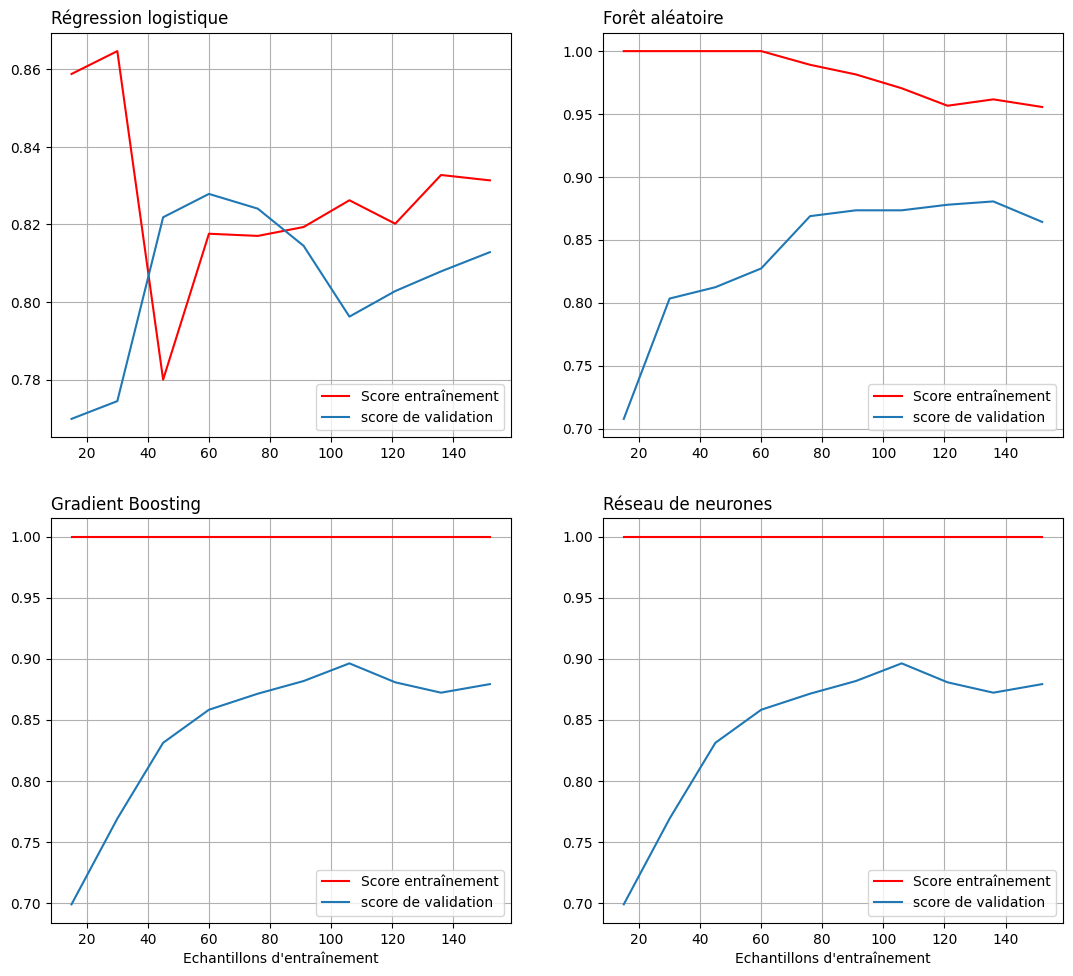

In [ ]:
# Initialise the subplot function using number of rows and columns
figure, axis = plt.subplots(2, 2, figsize=(15, 10))

# For LR
axis[0][0].plot(N_LR, train_score_LR.mean(axis=1), color = "red")
axis[0][0].plot(N_LR, val_score_LR.mean(axis=1))
axis[0][0].set_title("Régression logistique", loc = "left")
axis[0][0].legend(['Score entraînement', 'score de validation'], loc = "lower right")
axis[0][0].grid(visible = None)
# For RF
axis[0][1].plot(N_RF, train_score_RF.mean(axis=1), color = "red")
axis[0][1].plot(N_RF, val_score_RF.mean(axis=1))
axis[0][1].set_title("Forêt aléatoire", loc = "left")
axis[0][1].legend(['Score entraînement', 'score de validation'], loc = "lower right")
axis[0][1].grid(visible = None)
# For GB
axis[1][0].plot(N_GB, train_score_GB.mean(axis=1), color = "red")
axis[1][0].plot(N_GB, val_score_GB.mean(axis=1))
axis[1][0].set_title("Gradient Boosting", loc = "left")
axis[1][0].legend(['Score entraînement', 'score de validation'])
axis[1][0].set_xlabel("Echantillons d'entraînement" )
axis[1][0].grid(visible = None)
# For ANN
axis[1][1].plot(N_GB, train_score_GB.mean(axis=1), color = "red")
axis[1][1].plot(N_GB, val_score_GB.mean(axis=1))
axis[1][1].set_title("Réseau de neurones", loc = "left")
axis[1][1].legend(['Score entraînement', 'score de validation'])
axis[1][1].set_xlabel("Echantillons d'entraînement" )
axis[1][1].grid(visible = None)
plt.subplots_adjust(bottom=0.01, right=0.8, top=0.9)
 # To save the figure
plt.savefig('Learning_curve_Aex_ML.png', bbox_inches='tight');
